In [137]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

# simplest simulation: markov between 2 leagues

In [138]:
# initial state
n_league1 = 100
n_league2 = 0

In [139]:
# parameters of league change
p11 = 0.8
p22 = 0.6
ptrans = [[p11,1-p11],[1-p22,p22]]


In [140]:
nstep = 400
# start simulation
n1,n2 = n_league1,n_league2
simudata = []
simudata.append({
        'time_step':0,
        'n1':n1,
        'n2':n2

})
for kstep in range(nstep):
    n_11 = sum(np.random.rand(n1)<p11)
    n_12 = n1-n_11
    
    n_22 = sum(np.random.rand(n2)<p22)
    n_21 = n2-n_22
    
    n1 = n_11 + n_21
    n2 = n_22 + n_12
    
    simudata.append( {
        'time_step':kstep,
        'n1':n1,
        'n2':n2
    })
simudata = pd.DataFrame(simudata)

In [141]:
simudata

,time_step,n1,n2
0,0,100,0
1,0,85,15
2,1,80,20
3,2,70,30
4,3,65,35
...,...,...,...
396,395,62,38
397,396,62,38
398,397,70,30
399,398,68,32


In [142]:
px.line(simudata,x='time_step',y=['n1','n2'],labels={'variable':'number of DAO in each league'})

An initial big change (many league 1 converts to league 2), then stablize.

# How does the league transition impacts NEAR funding?

In [143]:
# initial variable
n1 = 100
n2 = 0
total_nearfund=0

In [144]:
# parameters 
p11 = 0.8
p22 = 0.6
near_fund_eachstep = [1,5] # how much fund is granted for each dao depending on their league. More fundings for league 2


In [145]:
nstep = 400

In [146]:
# start simulation
simudata = []
simudata.append({
        'time_step':0,
        'n1':n1,
        'n2':n2,
        'step_nearfund_granted':near_fund_eachstep[0]*n1 + near_fund_eachstep[1]*n2,
        'total_nearfund_granted':total_nearfund + near_fund_eachstep[0]*n1 + near_fund_eachstep[1]*n2

})
for kstep in range(nstep):
    n_11 = sum(np.random.rand(n1)<p11)
    n_12 = n1-n_11
    
    n_22 = sum(np.random.rand(n2)<p22)
    n_21 = n2-n_22
    
    n1 = n_11 + n_21
    n2 = n_22 + n_12
    
    nearfund_step = near_fund_eachstep[0]*n1 + near_fund_eachstep[1]*n2
    total_nearfund = total_nearfund + nearfund_step
    simudata.append( {
        'time_step':kstep,
        'n1':n1,
        'n2':n2,
        'step_nearfund_granted':nearfund_step,        
        'total_nearfund_granted':total_nearfund
    })
    
simudata = pd.DataFrame(simudata)

In [147]:
px.line(simudata,x='time_step',y=['step_nearfund_granted'])

No surprise, the near fund granted at each step is around a given range since the number of leagues is fluctuating around a certain number

TODO: 1) introduce natural growth of league 1? 2) add the impact backflow to the system. add that system revenue as a parameter too

# todo
## system health metrics
peole: league 2 has more funding=> people more likely to stay

funding flow

## changes of model parameters
growth and need of fund, different curves.

1) adding the failure rate of daos (league 2 may rather fail than going back to league 1)
2) life cycle of a dao:
2.1) profit (+ impact?) generated by dao
2.2) cost of running the dao
2.3) critical point: achieve break even (could be a percentage achieving break even)
3) near funding policy
One proposal: for L1, no condition for funding; for L2, "prove yourself by increase of profit, being more self-sustained or impact"
4) not immediate promotion of L2
5) *add new dao, when near has extra funding

## next step
- individual dao's life cycle simulation
    - changing the near policy
    - allowing the impact as a "revenue"?

# Individual DAO's life cycle

In [148]:
def curve_generator(timestep,**params):
    if params['curvetype']=='saturate':
        a = params['speed']
        b = params['maximum']
        c = params['start']
        assert b>c ,'minimum should be bigger than the start'
        return (1/(1 + np.exp(-a*timestep)) - .5) *(b-c)*2 + c
    if params['curvetype']=='logistic':
        a = params['speed']
        b = params['maximum']
        c = params['start']
        t0 = params['midpoint'] # when the exponential growth switch to linear / sublinear
        assert b>c ,'minimum should be bigger than the start'
        return (1/(1 + np.exp(-a*(timestep-t0))) - 1/(1+np.exp(a*t0))) *(b-c)/(1-1/(1+np.exp(a*t0))) +c

In [149]:
# models and parameters
def daocost_change(timestep,state_history,**params):
    return curve_generator(timestep,**params)
def daoincome_change(timestep,state_history,**params): # right now, same function as cost
    return curve_generator(timestep,**params)        
    
    

Text(0.5, 1.0, 'logistic')

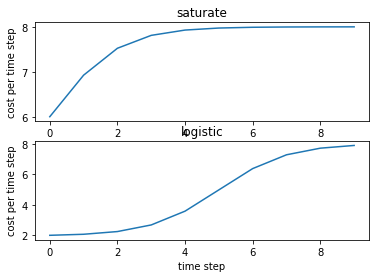

In [150]:
# play with the cost function to see what it looks like
plt.subplot(211)
curve=['saturate','logistic']
plt.plot([daocost_change(t,[],curvetype=curve[0],maximum=8,speed=1,start=6) for t in range(10)])
plt.xlabel('time step')
plt.ylabel('cost per time step')
plt.title(curve[0])
plt.subplot(212)
plt.plot([daocost_change(t,[],curvetype=curve[1],maximum=8,speed=1,start=2,midpoint=5) for t in range(10)])
plt.xlabel('time step')
plt.ylabel('cost per time step')
plt.title(curve[1])


Text(0.5, 1.0, 'logistic')

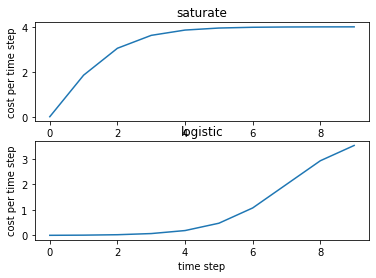

In [151]:
# play with the profit function to see what it looks like
plt.subplot(211)
curve=['saturate','logistic']
plt.plot([daoincome_change(t,[],curvetype=curve[0],maximum=4,speed=1,start=0) for t in range(10)])
plt.xlabel('time step')
plt.ylabel('cost per time step')
plt.title(curve[0])
plt.subplot(212)
plt.plot([daoincome_change(t,[],curvetype=curve[1],maximum=4,speed=1,start=0,midpoint=7) for t in range(10)])
plt.xlabel('time step')
plt.ylabel('cost per time step')
plt.title(curve[1])


In [152]:
def nearfund2dao_change(timestep,state_history,**params): 
    if params['curvetype']=='constant':
        a = params['amount']
        return a,'L1'
    if params['curvetype']=='step':
        a1 = params['L1amount']
        a2 = params['L2amount']
        league_policy = params['league_policy']
        leaguenow = league_policy(state_history)
        if leaguenow=='L2':            
            return a2,'L2'
        else:
            return a1,'L1'
        


In [153]:
# finally, the state update model
def daovariable_change(daotreasury,costmodel,incomemodel,fundmodel,timestep,state_history):
    cost_T = daocost_change(timestep,state_history,**costmodel)
    income_T = daoincome_change(timestep,state_history,**incomemodel) 
    fund_T,league_T=nearfund2dao_change(timestep,state_history,**fundmodel)
    netgain_T = income_T + fund_T - cost_T
    treasurey_T = daotreasury + netgain_T
    return {'treasury':treasurey_T,'cost_step':cost_T,'income_step':income_T,'nearfund_step':fund_T,'netgain_step':netgain_T,'league':league_T}
    

In [154]:
def runsimu(Nstep,ini_treasury,models):
    # simulation engine, putting things together
    var_list = []
    #initialize
    treasury_t = ini_treasury
    for t in range(Nstep):
        var_t = daovariable_change(treasury_t,models['costmodel'],models['incomemodel'],models['fundmodel'],t,var_list)
        
        var_list.append(var_t)
        treasury_t = var_t['treasury']
        if treasury_t < 0: # the DAO "dead", so just stop simulation
            var_list+=[{'treasury':np.nan,'cost_step':np.nan,'income_step':np.nan,'netgain_step':np.nan,'nearfund_step':np.nan} for k in range(Nstep-t-1)]
            break
    
    simu_df = pd.DataFrame(var_list)
    return simu_df

In [155]:
def league_netgrowthrate(state_history):
    if len(state_history)<3:
        return 'L1'
    if state_history[-1]['league']=='L2':
        return 'L2' # policy assumes no downgrade
    state1 = state_history[-1]
    net1 = state1['netgain_step']
    state2 = state_history[-2]
    net2 = state2['netgain_step']
    state3 = state_history[-3]
    net3 = state3['netgain_step']
    if (net1-net2 > net2-net3) and net1>5:
        return 'L2'
    else:
        return 'L1'

## type A: slow growth



Assumption: 

1) a steady funding stream from near (constant amount at each time step)

2) cost and income for this dao will be increasing gradually, reaching a plateu after a while. The rate of growth and the cap are different for cost and income

### story 1:  successfully sustaining

In [156]:
# put it together! show the life cycle in terms of net profit each time step
# first, define the near funding policy
fundmodel = {'curvetype':'step','L1amount':10,'L2amount':35,'league_policy':league_netgrowthrate}
   

In [157]:
# second, specify the growing trajectory for this specific DAO
# state variables
daotreasury = 0
daocost = 10 # cost to run this dao in each time step 
daoincome = 1 # external funding being raised in each time step

# so at the beginning, the income is lower than the cost

costmodel = {'curvetype':'saturate','maximum':daocost*1.2,'speed':0.8,'start':daocost}
incomemodel = {'curvetype':'saturate','maximum':daoincome*10,'speed':0.5,'start':daoincome}


In [158]:
Nstep = 10
var_df = runsimu(Nstep,daotreasury,{'costmodel':costmodel,'incomemodel':incomemodel,'fundmodel':fundmodel})


In [159]:
px.line(var_df,y=['treasury'])

In [160]:
px.line(var_df,y=['cost_step','income_step','nearfund_step','netgain_step'])

Story here: near fund is enough to cover the initial cost to let the DAO grow until it reaches a steady point so part of their own income could contribute to cover all the costs and this DAO can survive

### story 2: fail to sustain

adjusting the cost growth speed to be much higher and income is much slower. 

In [161]:
#fundmodel = {'curvetype':'constant','amount':15}
fundmodel = {'curvetype':'step','L1amount':15,'L2amount':20,'league_policy':league_netgrowthrate}


# second, specify the growing trajectory for this specific DAO
# state variables
daotreasury = 0
daocost = 10 # cost to run this dao in each time step 
daoincome = 1 # external funding being raised in each time step

# so at the beginning, the income is lower than the cost

costmodel = {'curvetype':'saturate','maximum':daocost*1.2,'speed':1.5,'start':daocost}
incomemodel = {'curvetype':'saturate','maximum':daoincome*10,'speed':0.2,'start':daoincome}


In [162]:
Nstep = 10
var_df = runsimu(Nstep,daotreasury,{'costmodel':costmodel,'incomemodel':incomemodel,'fundmodel':fundmodel})
px.line(var_df,y=['treasury'])

In [163]:
px.line(var_df,y=['cost_step','income_step','nearfund_step'])

story here: the growth of income is so slow that it can't sustain for more than 4 time steps

### story 3: almost failed but funding helped it sustain

adjusting the near funding to be higher

In [164]:
#fundmodel = {'curvetype':'constant','amount':16}
fundmodel = {'curvetype':'step','L1amount':16,'L2amount':20,'league_policy':league_netgrowthrate}


# second, specify the growing trajectory for this specific DAO
# state variables
daotreasury = 0
daocost = 10 # cost to run this dao in each time step 
daoincome = 1 # external funding being raised in each time step

# so at the beginning, the income is lower than the cost

costmodel = {'curvetype':'saturate','maximum':daocost*1.2,'speed':1.5,'start':daocost}
incomemodel = {'curvetype':'saturate','maximum':daoincome*10,'speed':0.2,'start':daoincome}

# start simulation
Nstep = 10
var_df = runsimu(Nstep,daotreasury,{'costmodel':costmodel,'incomemodel':incomemodel,'fundmodel':fundmodel})
px.line(var_df,y=['treasury'])

In [165]:
px.line(var_df,y=['cost_step','income_step','nearfund_step','netgain_step'])

story here: similarly slow growth of income, but because near fund is slightly higher, it was able to get over the initial "money burning" and survive to better growth.

## type B: faster growth that needs higher funding

In [166]:
fundmodel = {'curvetype':'step','L1amount':10,'L2amount':20,'league_policy':league_netgrowthrate}

# second, specify the growing trajectory for this specific DAO
# state variables
daotreasury = 0
daocost = 10 # cost to run this dao in each time step 
daoincome = 1 # external funding being raised in each time step

# so at the beginning, the profit is lower than the cost

costmodel = {'curvetype':'logistic','maximum':daocost*1.2,'speed':1.5,'start':daocost,'midpoint':7}
incomemodel = {'curvetype':'logistic','maximum':daoincome*20,'speed':1.2,'start':daoincome,'midpoint':6}

# start simulation
Nstep = 13
var_df = runsimu(Nstep,daotreasury,{'costmodel':costmodel,'incomemodel':incomemodel,'fundmodel':fundmodel})
px.line(var_df,y=['treasury'])

In [167]:
px.line(var_df,y=['cost_step','income_step','nearfund_step','netgain_step'])

1. when the income growth is faster than cost increase, the league policy successfully recognized that and gave this organization a promotion
2. not yet capturing how the higher near funding is helping this dao based on the current assumptions where the growth of income and cost is only a function of time. Because this dao is on such a good track, there's no chance for them to go broke. Therefore, whatever near fund is doing won't affect them a lot.

**TODO**: more stories, suggested by phill.
1. 30% of DAOs just fail after X steps
2. 60% of DAOs break even after X steps, and only use 20% of funding from Near from now on (the rest of its cost is covered by its own income)
3. 10% of DAOs overperform and generate 10x or 50x revenue than their cost

# multiple agents to simulate the whole ecosystem

- set up constraint of total fund from NEAR
    - when can league 2 become self-reliant, NEAR stops to fund
- how can league 2 "give back"? E.g. gas. cross-dao transaction
- sustainability metrics: dying of daos (i.e. total number of daos). Income and revenue.


In [231]:
# Initialize funding policy
fundmodel = {'curvetype':'step','L1amount':10,'L2amount':20,'league_policy':league_netgrowthrate}
daotreasury = 1 # initial treasury for every dao

# Initialize player distribution
daolist = []
for k in range(3):
    daocostmodel = {'curvetype':'saturate','maximum':15+np.random.randint(3),'speed':.2+np.random.rand()*8,'start':4+6*np.random.rand()}
    daoincomemodel = {'curvetype':'saturate','maximum':10,'speed':0.2,'start':1}
    daolist.append({'incomemodel':daoincomemodel,'costmodel':daocostmodel,'ini_treasury':daotreasury})

for k in range(6): # self-sustained models
    daocostmodel = {'curvetype':'saturate','maximum':22,'speed':.8+np.random.rand()*8,'start':8}
    daoincomemodel = {'curvetype':'saturate','maximum':20+np.random.randint(6),'speed':1.2,'start':1}
    daolist.append({'incomemodel':daoincomemodel,'costmodel':daocostmodel,'ini_treasury':daotreasury})

for k in range(2): # crazy successful models
    daocostmodel = {'curvetype':'logistic','maximum':50,'speed':.8+np.random.rand()*8,'start':8,'midpoint':4}
    daoincomemodel = {'curvetype':'logistic','maximum':60+np.random.randint(6),'speed':1.2,'start':1,'midpoint':4}
    daolist.append({'incomemodel':daoincomemodel,'costmodel':daocostmodel,'ini_treasury':daotreasury})

In [232]:
# System simulation
def runsyssimu(Nstep,daolist,fundmodel):
    sysvar_steps = [{'totaltreasury':0,'ndao':0,'steptransaction':0,'stepnearfund':0} for k in range(Nstep)]
    daosimu_list =[]
    for daomodel in daolist:        
        var_list = []
        #initialize
        treasury_t = daomodel['ini_treasury']
        for t in range(Nstep):
            var_t = daovariable_change(treasury_t,daomodel['costmodel'],daomodel['incomemodel'],fundmodel,t,var_list)
            var_list.append(var_t)
            treasury_t = var_t['treasury']
            if treasury_t < 0: # the DAO "dead", so just stop simulation
                var_list+=[{'treasury':np.nan,'cost_step':np.nan,'income_step':np.nan,'netgain_step':np.nan,'nearfund_step':np.nan} for k in range(Nstep-t-1)]
                break
            else:
                sysvar_steps[t]['totaltreasury'] += treasury_t
                sysvar_steps[t]['ndao'] +=1
                sysvar_steps[t]['steptransaction'] += var_t['income_step']+var_t['cost_step']                
                sysvar_steps[t]['stepnearfund'] +=var_t['nearfund_step']

        daosimu_df = pd.DataFrame(var_list)
        daosimu_list.append(daosimu_df)
    sysvar_df = pd.DataFrame(sysvar_steps)
    return sysvar_df,daosimu_list

In [233]:
# let's run it!
Nstep=8
sysvar_df,daosimu_list = runsyssimu(Nstep,daolist,fundmodel)

# What should be the system health metrics?? 
# potential: 1) total number of DAOs 2) total DAO transactions (cost and income)

In [235]:
px.line(sysvar_df,y=['ndao'])

In [236]:
px.line(sysvar_df,y=['stepnearfund','steptransaction'])

In [230]:
px.line(sysvar_df,y=['totaltreasury'])